# References:
* https://github.com/d9w/evolution/tree/master/1_introduction

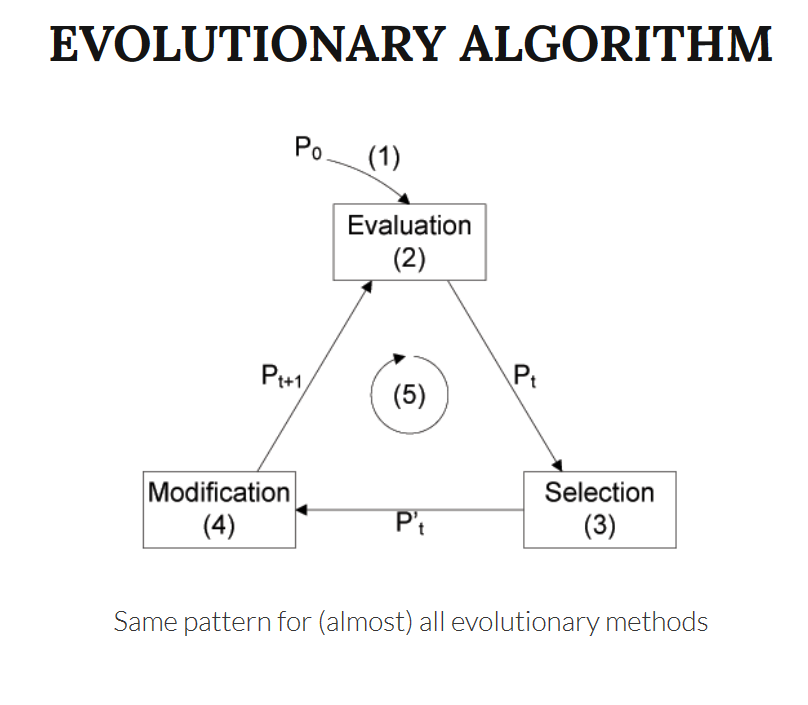

In [1]:
from dataclasses import dataclass
import random
from math import log
import matplotlib.pyplot as plt
import numpy as np

# Individual 


The base unit of an evolutionary algorithm is the individual. An individual represents a single solution to the problem we want to solve. 
Indviduals contains:
* genes or input
* fitness or ouput


Here we've defined a new type, Individual which has binary genes and an integer fitness. When we construct a new individual, we use random genes and set the default fitness to 0. For these examples we'll be using objective functions which have positive fitness values.


In [2]:
# Individual is are genes or input

@dataclass
class Individual:
    genes : list
    fitness : float = 0.0

def CreateIndividual(n):
    return Individual([random.getrandbits(1) for _ in range(n)],0)

## Test
n = 10
ind = CreateIndividual(n)
print(ind)

Individual(genes=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1], fitness=0)


# Objective fucntion
An objective function is a function which gives a value to our individual. A strength of evolutionary algorithms is that this objective function can be anything as long as it evaluates the individual. Unlike other optimization methods, this function does not need to be differentiable or continuous.

## One Max Objective Function
OneMax function, which simply adds all of the bits of the genotype. The optimal fitness for this function is therefore when the entire genotype is 1. This simple function has been well-studied and generalizes well to the search of any specific bit string.

In [3]:
def onemax(ind:Individual):
    return sum(ind.genes)

ind, onemax(ind)

(Individual(genes=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1], fitness=0), 4)



As we can see, the fitness of our individual is the number of 1s in the function.


# Fitness
* Fitness is the output of the objective function
* Fitness is the evaulation of the objective function given the individual


In order to be more general later, we'll write an evaluate function which can take any objective function.

In [4]:
def evaluate(ind : Individual, objective):
    ind.fitness = objective(ind)
    
# test
evaluate(ind, onemax)
ind

Individual(genes=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1], fitness=4)

Now that we have our individuals defined and we have an objective function, we're ready to write our first evolutionary algorithm.

# (1+1) Evolutionary Algorithm

The first algorithm we'll implement is the simplest evolutionary algorithm, the (1+1) Evolutionary Algorithm:

Choose randomly an initial bit string $x∈ \{0;1\}$

Repeat the following mutation step:
* Compute $x′$ by flipping independently each bit $x_i$ with probability $p$
* Replace $x$ by $x′$ if $f(x′) \geq f(x)$.

We'll start by defining the first random individual


In [5]:
parent = CreateIndividual(n)
evaluate(parent, onemax)
parent

Individual(genes=[0, 1, 1, 1, 1, 0, 0, 0, 1, 0], fitness=5)



Let's define the mutation step as a function. This will make our code more organized and has the advantage that compilation will optimize this part of the code. We'll use the probability of $p=\frac{1}{n}$, where $n$ is the number of bits. 


In [6]:
def mutate(ind:Individual):
    new_genes = list(ind.genes)
    mutation_rate = 1.0/len(ind.genes)
    
    for index, _ in enumerate(new_genes):
        if random.random() < mutation_rate:
            new_genes[index] = ~ind.genes[index] & 1
    
    return Individual(new_genes, 0)

# test
new_genes = mutate(ind)
ind, new_genes

(Individual(genes=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1], fitness=4),
 Individual(genes=[0, 0, 0, 1, 0, 1, 0, 0, 1, 1], fitness=0))

let's mutate the parent to get a child

In [7]:
child = mutate(parent)
evaluate(child, onemax)
print(parent.genes == child.genes)

True




Try running this a few times and you'll see that most of the time, only one gene changes. That makes sense due to the $p=\frac{1}{n}$ mutation rate we set. This means that evolution will move rather slowly towards the optimal bitstring, on average only 1 change at a time.

Now that we have the new individual, we can do the last part of our algorithm: Replace $x$ by $x′$ if $f(x′) \geq f(x)$.


In [8]:
if child.fitness >= parent.fitness:
    parent = child
    
parent.fitness

5

That's all there is to the (1+1) EA. We simply run this mutation step over and over until we reach the solution we want or stop the computation. Let's look at just a few iterations:

In [9]:
for i in range(5):
    child = mutate(parent)
    evaluate(child, onemax)
    if child.fitness >= parent.fitness:
        parent = child
        
print(parent.fitness)

9


So in a few generations, we can see improvement. To study how long it will take for this to reach the OneMax solution, let's first define everything we've done until now as a function.

In [10]:
def one_plus_one(ind_length:int, num_generations: int, f):
    fits = [0] * num_generations
    parent = CreateIndividual(ind_length)
    evaluate(parent, f)
    
    for index, _ in enumerate(fits):
        child = mutate(parent)
        evaluate(child, f)
        
        if child.fitness >= parent.fitness:
            parent = child
        
        fits[index] = parent.fitness
    
    return fits      



Since evolutionary algorithms are stochastic, it's hard to guarantee their exact computational complexity. You can prove the worst case, but a more useful metric is the expected number of generations to reach the optimal solution. For linear objective functions such as the OneMax problem, the expected runtime for the (1+1) EA has been proven to to be $0(n \log n)$, where $n$ is the number of independent binary variables (ie, the length of the genome). This proof is beyond the scope of this class, but I recommend looking at the linked publications in this notebook. Note that this is only for the case of a mutation rate of $\frac{1}{n}$, which is why we used it as our default value before.


Let's run our (1+1) EA with $n \log n$ as our number of generations.

975


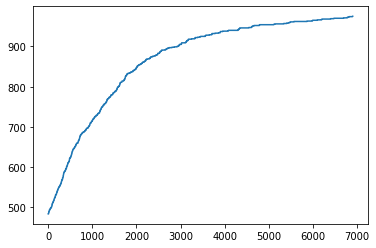

In [11]:
n = 1000
fits = one_plus_one(n, int(n*log(n)), onemax)
print(fits[len(fits) - 1])
plt.plot(fits)

This isn't yet $n$ but its very close, which is what the expected time guarantees: $n \log n$ is the average value of when the (1+1) EA converges. The worst case for a binary (1+1) EA on any function is to converge in $O(n^n)$, but we don't need to run it for that long to see convergence.

999


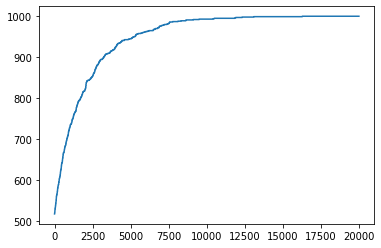

In [12]:
n = 1000
fits = one_plus_one(n, 20000, onemax)
print(fits[len(fits) - 1])
plt.plot(fits)

# Objective Function - Leading Ones

The Leading Ones problem is another well-studied binary problem which counts the number of leading ones from left to right, stopping when the first zero-bit is found. In other words, the fitness of this function is:

$f(x) := \sum_{i=1}^n \prod_{j=1}^1 x_j$

In our implementation, we'll just count the indices and stop when we reach a 0.


In [13]:
def leading_ones(ind:Individual):
    f = 0
    
    for index, _ in enumerate(ind.genes):
        if ~ind.genes[index] & 1:
            f = index + 1
            break
    
    return f

Run the (1+1) EA on the Leading Ones problem. Does it converge near $0(n \log n)$, or $O(n^2)$? 

9


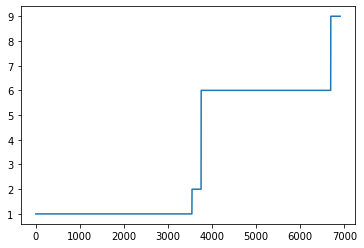

In [14]:
n = 1000
fits = one_plus_one(n, int(n*log(n)), leading_ones)
print(fits[len(fits) - 1])
plt.plot(fits)

100


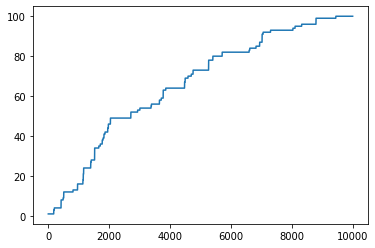

In [15]:
n = 100
fits = one_plus_one(n, n**2, leading_ones)
print(fits[len(fits) - 1])
plt.plot(fits)


$(1+\lambda)$ Evolutionary Algorithm

The next algorithm that we'll see is a small change on the (1+1) EA. Instead of generating one individual each iteration (generation) we'll make $\lambda$. This can be considered our population. This small change means the $(1+\lambda)$ algorithm is still very simple, but this simple algorithm is used in state-of-the-art Genetic Programming methods to do perform complex tasks.

The $(1+\lambda) EA$ introduces a new parameter: population size. What should we choose for this parameter? Recent theoretical work has demonstrated that the expected running time of the $(1+\lambda)$ EA on any linear function is $O(\frac{1}{λ} n \log n + n)$ under the condition that $\lambda = O(\log n \log \log n / \log \log \log n)$. We could try that.


In [16]:
n = 100
𝜆 = int(round(log(n)*log(log(n))/log(log(log(n)))))
𝜆

17

But let's keep things simple and just use 10.

In [17]:
𝜆 = 10

We'll rewrite our one_plus_one function, this time using a population of individuals. We'll keep track of the best new individual in order to compare it with the expert(parent) for replacement in the next generation.

In [18]:
def one_plus_lambda(ind_length:int, num_generations:int, f, 𝜆:int):
    
    fits = [0]*(num_generations)
    expert = CreateIndividual(ind_length)
    evaluate(expert, f)
    
    for index, _ in enumerate(fits):
        population = [CreateIndividual(ind_length) for _ in range(𝜆)]
        best = 0
        for j, _ in enumerate(population):
            population[j] = mutate(expert)
            evaluate(population[j], f)
            if population[j].fitness > population[best].fitness:
                best = j
        
        if population[best].fitness >= expert.fitness:
            expert = population[best]

        fits[index] = expert.fitness
    return fits



Let's see how these two methods compare on the OneMax problem.


In [19]:
n = 100
n_gens = 1000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, n_gens, onemax, 𝜆)
fits_1[-1], fits_𝜆[-1]

(100, 100)

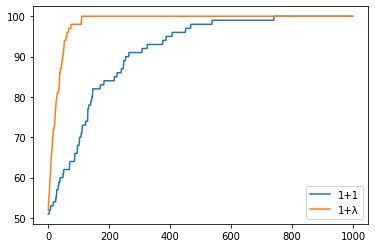

In [20]:
plt.plot(fits_1, label="1+1")
plt.plot(fits_λ, label="1+λ")
plt.legend(loc="lower right")



A more fair comparison would be to give each algorithm the same number of function evaluations, like this:


(10000, 1000)

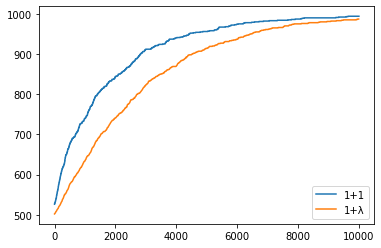

In [21]:
n = 1000
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, onemax)
fits_𝜆 = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)
plt.plot(fits_1, label="1+1")
plt.plot(range(0,n_gens,𝜆),fits_𝜆, label="1+λ")
plt.legend(loc="lower right")
len(fits_1), len(fits_𝜆)



Because evolutionary algorithms are entirely based on randomness, it is a good practice to run them multiple times to have an idea about their performance. We'll run this 10 times, but more is often a good idea, depending on the distribution of final results.


In [22]:
n_trials = 10
n = 100
n_gens = 1000

fits_1 = np.zeros((n_trials, n_gens))
fits_𝜆 = np.zeros((n_trials, int(n_gens/𝜆)))

for i in range(n_trials):
    fits_1[i,:] = one_plus_one(n, n_gens, onemax)
    fits_𝜆[i,:] = one_plus_lambda(n, int(n_gens/𝜆), onemax, 𝜆)

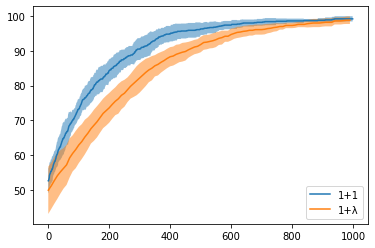

In [23]:
μ_1 = np.mean(fits_1, axis=0)
σ_1 = np.std(fits_1, axis=0)
μ_𝜆 = np.mean(fits_𝜆, axis=0)
σ_𝜆 = np.std(fits_𝜆, axis=0)
plt.plot(range(0,n_gens), μ_1, label="1+1")
plt.fill_between(range(0,n_gens), μ_1-σ_1, μ_1+σ_1, alpha=0.5)
plt.plot(range(0,n_gens,𝜆), μ_𝜆, label="1+λ")
plt.fill_between(range(0,n_gens,𝜆), μ_𝜆-σ_𝜆, μ_𝜆+σ_𝜆, alpha=0.5)
plt.legend(loc="lower right")

Compare the (1+1) EA and $(1+\lambda)$ EA on the Leading Ones problem 

(10000, 1000)

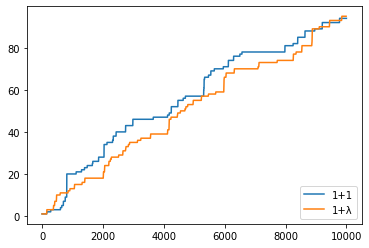

In [24]:
n = 100
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, leading_ones)
fits_𝜆 = one_plus_lambda(n, int(n_gens/𝜆), leading_ones, 𝜆)
plt.plot(fits_1, label="1+1")
plt.plot(range(0,n_gens,𝜆),fits_𝜆, label="1+λ")
plt.legend(loc="lower right")
len(fits_1), len(fits_𝜆)

In [25]:
n_trials = 10
n = 100
n_gens = 10000

fits_1 = np.zeros((n_trials, n_gens))
fits_𝜆 = np.zeros((n_trials, int(n_gens/𝜆)))

for i in range(n_trials):
    fits_1[i,:] = one_plus_one(n, n_gens, leading_ones)
    fits_𝜆[i,:] = one_plus_lambda(n, int(n_gens/𝜆), leading_ones, 𝜆)

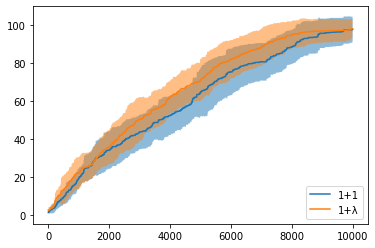

In [26]:
μ_1 = np.mean(fits_1, axis=0)
σ_1 = np.std(fits_1, axis=0)
μ_𝜆 = np.mean(fits_𝜆, axis=0)
σ_𝜆 = np.std(fits_𝜆, axis=0)
plt.plot(range(0,n_gens), μ_1, label="1+1")
plt.fill_between(range(0,n_gens), μ_1-σ_1, μ_1+σ_1, alpha=0.5)
plt.plot(range(0,n_gens,𝜆), μ_𝜆, label="1+λ")
plt.fill_between(range(0,n_gens,𝜆), μ_𝜆-σ_𝜆, μ_𝜆+σ_𝜆, alpha=0.5)
plt.legend(loc="lower right")


# Continuous optimization

So far we've looked at the case of binary functions. However, these algorithms can be used for any objective function and genotype definition. Let's look at the case of continuous optimization, which optimized over real numbers. For that, we'll need to define a new Individual type. Instead of random bits, this individual will have random numbers for its genes. We'll look at the case of uniformly distributed random numbers between 0 and 1.


In [27]:
@dataclass
class FloatIndividual:
    genes : list
    fitness : float = 0
    
def CreateFloatIndividual(n:int):
    return FloatIndividual([random.random() for _ in range(n)], 0)

# test
n = 10
ind = CreateFloatIndividual(n)
ind

FloatIndividual(genes=[0.744514079828369, 0.6405861333434976, 0.9816106525045689, 0.19596496917068007, 0.28135496045616526, 0.6614518808971792, 0.3651301449044583, 0.9715148802491046, 0.35023799584036874, 0.35229301316201556], fitness=0)

We also need to define a new mutation function. Instead of flipping bits, we'll just draw a new random number.

In [28]:
def mutate(ind:FloatIndividual):
    new_genes = list(ind.genes)
    mutation_rate = 1.0/len(ind.genes)
    
    for index, _ in enumerate(new_genes):
        if random.random() < 1:#mutation_rate:
            new_genes[index] = random.random()
    
    return FloatIndividual(new_genes, 0)

child = mutate(ind)
print(ind.genes == child.genes)

False


One of the most classic continuous optimization problems is the sphere function. This function simply gives the distance from an optimal point in all dimensions.

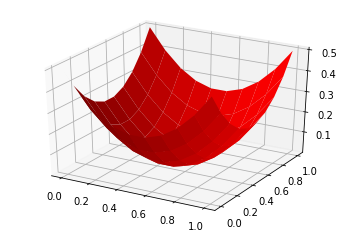

In [29]:
x = np.linspace(0,1,10)
y = np.linspace(0,1,10)
X, Y = np.meshgrid(x,y)
fz = (X-0.5)**2 + (Y-0.5)**2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fz, color='r')

In [30]:
def sphere(ind:FloatIndividual, center:float = 0.5):
    f = 0
    for g in ind.genes:
        f += (g - center)**2
    return -f

sphere(ind)

-0.7625722518228996

# Exercise
Use the FloatIndividual to compare the (1+1) EA and $(1+\lambda)$ EA on the sphere problem. You'll need to change the definition of one_plus_one and one_plus_lambda to use the FloatIndividual type. 

In [31]:
def one_plus_one(ind_length:int, num_generations: int, f):
    fits = [0] * num_generations
    parent = CreateFloatIndividual(ind_length)
    evaluate(parent, f)
    
    for index, _ in enumerate(fits):
        child = mutate(parent)
        evaluate(child, f)
        
        if child.fitness >= parent.fitness:
            parent = child
        
        fits[index] = parent.fitness
    
    return fits     

In [32]:
def one_plus_lambda(ind_length:int, num_generations:int, f, 𝜆:int):
    
    fits = [0]*(num_generations)
    expert = CreateFloatIndividual(ind_length)
    evaluate(expert, f)
    
    for index, _ in enumerate(fits):
        population = [CreateIndividual(ind_length) for _ in range(𝜆)]
        best = 0
        for j, _ in enumerate(population):
            population[j] = mutate(expert)
            evaluate(population[j], f)
            if population[j].fitness > population[best].fitness:
                best = j
        
        if population[best].fitness >= expert.fitness:
            expert = population[best]

        fits[index] = expert.fitness
    return fits

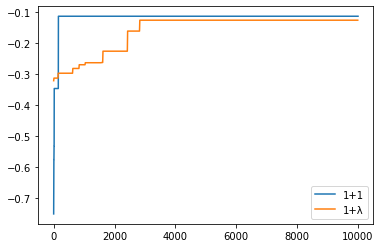

In [33]:
n = 10
n_gens = 10000
fits_1 = one_plus_one(n, n_gens, sphere)
fits_𝜆 = one_plus_lambda(n, int(n_gens/𝜆), sphere, 𝜆)
plt.plot(fits_1, label="1+1")
plt.plot(range(0,n_gens,𝜆),fits_𝜆, label="1+λ")
plt.legend(loc="lower right")